### Model Portfolio Max Sharpe Ratio

In [2]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from dotenv import load_dotenv
import os

# Load credentials
load_dotenv()
login = int(os.getenv("AQUA_MT5_LOGIN"))
password = os.getenv("AQUA_MT5_PASSWORD")
server = os.getenv("AQUA_MT5_SERVER")

# Initialize MT5
if not mt5.initialize(login=login, password=password, server=server):
    print("initialize() failed, error code =", mt5.last_error())
    quit()

# Fetch MT5 data
def fetch_mt5_data(symbol, days=60):
    utc_from = pd.Timestamp.now() - pd.Timedelta(days=days)
    rates = mt5.copy_rates_from(symbol, mt5.TIMEFRAME_D1, utc_from, days)
    if rates is None:
        raise ValueError(f"Failed to fetch data for {symbol}")
    df = pd.DataFrame(rates)
    df["time"] = pd.to_datetime(df["time"], unit="s")
    return df

# Daily returns
def calculate_daily_returns(prices):
    return prices.pct_change().dropna()

# Load expected daily returns
expected_returns_df = pd.read_csv("expected_return_aqua.csv", sep="\t", header=None)
expected_returns_dict = dict(zip(expected_returns_df[0], expected_returns_df[1]))

symbols = list(expected_returns_dict.keys())

# Fetch price data
data = {symbol: fetch_mt5_data(symbol) for symbol in symbols}
returns = pd.DataFrame({symbol: calculate_daily_returns(data[symbol]["close"]) for symbol in symbols})

# Covariance matrix (daily)
cov_matrix = returns.cov()

# Expected daily returns vector
expected_returns = np.array([expected_returns_dict[symbol] for symbol in symbols])

risk_free_rate = 0.0

# Max Sharpe optimization (daily)
def max_sharpe_ratio(expected_returns, cov_matrix, risk_free_rate=0.0):
    num_assets = len(expected_returns)

    def neg_sharpe(weights):
        port_ret = np.dot(weights, expected_returns)
        port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
        return -(port_ret - risk_free_rate) / port_vol

    constraints = [{"type": "eq", "fun": lambda w: np.sum(w) - 1}]
    bounds = [(-0.25, 0.25)] * num_assets
    init_guess = np.ones(num_assets) / num_assets

    result = minimize(neg_sharpe, init_guess, bounds=bounds, constraints=constraints)

    if not result.success:
        raise ValueError("Optimization failed")

    weights = result.x
    daily_ret = np.dot(weights, expected_returns)
    daily_vol = np.sqrt(weights.T @ cov_matrix @ weights)

    return weights, daily_ret, daily_vol

# Run optimization
weights, daily_port_return, daily_port_vol = max_sharpe_ratio(expected_returns, cov_matrix)

# Annualized values
annual_port_return = (1 + daily_port_return)**252 - 1
annual_port_vol = daily_port_vol * np.sqrt(252)
annual_sharpe = (annual_port_return) / annual_port_vol


# Output
print("\nOptimal Portfolio Weights:")
for symbol, weight in zip(symbols, weights):
    print(f"{symbol}: {weight:.4f}")

print("\n--- Portfolio Statistics ---")
print(f"Daily Portfolio Return: {daily_port_return:.2%}")
print(f"Annualized Portfolio Return: {annual_port_return:.2%}")
print(f"Daily Portfolio Volatility: {daily_port_vol:.2%}")
print(f"Annualized Portfolio Volatility: {annual_port_vol:.2%}")
print(f"Annualized Sharpe Ratio: {annual_sharpe:.2f}")

# Shutdown MT5
mt5.shutdown()


Optimal Portfolio Weights:
AUDUSD: 0.1630
EURUSD: 0.2500
GBPUSD: 0.0560
NZDUSD: -0.0102
USDJPY: 0.2500
USDCHF: 0.0559
USDCAD: 0.2500
XAGUSD: 0.0042
XAUUSD: -0.0076
WTI: -0.0112
BRENT: -0.0123
SPX500: 0.0294
US30: 0.0142
NAS100: 0.0330
GER40: -0.0195
JPN225: -0.0817
UK100: -0.0132
AUS200: 0.0499

--- Portfolio Statistics ---
Daily Portfolio Return: 0.60%
Annualized Portfolio Return: 346.40%
Daily Portfolio Volatility: 0.08%
Annualized Portfolio Volatility: 1.31%
Annualized Sharpe Ratio: 264.90


True

In [3]:
asset_daily_vol = returns.std()
print("\n--- Asset Daily Volatilities ---")
for symbol, vol in zip(symbols, asset_daily_vol):
    print(f"{symbol}: {vol:.2%}") 

# Export asset-level daily volatility to TSV (tab-separated, no header)
asset_daily_vol.to_csv(
    "aqua_funded_asset_daily_volatility.csv",
    sep="\t",
    header=False,
    index=True
)          


--- Asset Daily Volatilities ---
AUDUSD: 0.43%
EURUSD: 0.39%
GBPUSD: 0.39%
NZDUSD: 0.46%
USDJPY: 0.54%
USDCHF: 0.44%
USDCAD: 0.23%
XAGUSD: 1.91%
XAUUSD: 1.31%
WTI: 1.63%
BRENT: 1.50%
SPX500: 0.73%
US30: 0.81%
NAS100: 0.98%
GER40: 0.68%
JPN225: 1.64%
UK100: 0.49%
AUS200: 0.56%


### Correlation Past 60 Trading days

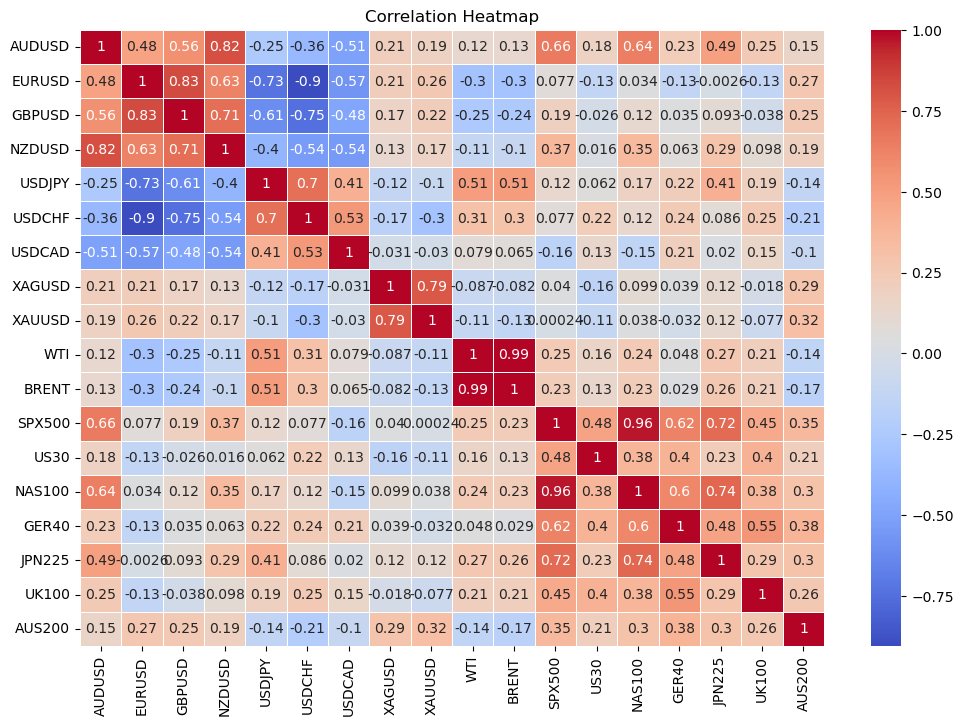

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = returns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

### Actual Weights

In [5]:
import pandas as pd
import numpy as np

# --- Load weights from comma-separated file ---
weights_df = pd.read_csv(
    "aqua_actual_weights.csv",
    header=None,
    engine="python",
    encoding="utf-8-sig"
)

weights_df.columns = ["asset", "weight"]

# Align weights to returns.columns order
weights_df = weights_df.set_index("asset").reindex(returns.columns)

# Extract weight vector
weights = weights_df["weight"].values

print("Loaded weights (aligned):")
print(weights)
print("\nAsset order:")
print(list(returns.columns))

# --- Portfolio calculations ---
cov_matrix = returns.cov()

# Daily volatility
portfolio_volatility = np.sqrt(weights.T @ cov_matrix.values @ weights)
annualized_volatility = portfolio_volatility * np.sqrt(252)

print(f"\n--- ORIGINAL PORTFOLIO ---")
print(f"Daily Portfolio Volatility: {portfolio_volatility:0.2%}")
print(f"Annualized Portfolio Volatility: {annualized_volatility:0.2%}")

# Historical return (not used for optimization)
portfolio_daily_returns = returns @ weights
avg_daily_return = portfolio_daily_returns.mean()
annualized_return = avg_daily_return * 252

sharpe_ratio = annualized_return / annualized_volatility

print(f"Average Daily Portfolio Return: {avg_daily_return:0.2%}")
print(f"Annualized Portfolio Return: {annualized_return:0.2%}")
print(f"Sharpe Ratio (annualized): {sharpe_ratio:.2f}")

# --- SCALE PORTFOLIO TO TARGET VOLATILITY ---
target_vol = 0.10   # 10% annual volatility

scale_factor = target_vol / annualized_volatility
scaled_weights = weights * scale_factor

# Recompute volatility after scaling
scaled_daily_vol = np.sqrt(scaled_weights.T @ cov_matrix.values @ scaled_weights)
scaled_annual_vol = scaled_daily_vol * np.sqrt(252)

print(f"\n--- SCALED PORTFOLIO (Target Vol = 10%) ---")
print(f"Scale Factor: {scale_factor:.4f}")
print(f"Scaled Annual Volatility: {scaled_annual_vol:0.2%}")

print("\nScaled Weights:")
for asset, w in zip(returns.columns, scaled_weights):
    print(f"{asset}: {w:.6f}")

Loaded weights (aligned):
[ 0.83531688  1.77391965 -0.2868594   0.32685836  2.75       -0.58687098
  1.13409401  0.12463142 -0.20848848  0.4059479  -0.78460722  1.52942454
 -0.4240237  -0.47717493 -0.58588275 -0.65486587 -0.18045946  0.90460682]

Asset order:
['AUDUSD', 'EURUSD', 'GBPUSD', 'NZDUSD', 'USDJPY', 'USDCHF', 'USDCAD', 'XAGUSD', 'XAUUSD', 'WTI', 'BRENT', 'SPX500', 'US30', 'NAS100', 'GER40', 'JPN225', 'UK100', 'AUS200']

--- ORIGINAL PORTFOLIO ---
Daily Portfolio Volatility: 0.91%
Annualized Portfolio Volatility: 14.37%
Average Daily Portfolio Return: -0.04%
Annualized Portfolio Return: -10.08%
Sharpe Ratio (annualized): -0.70

--- SCALED PORTFOLIO (Target Vol = 10%) ---
Scale Factor: 0.6959
Scaled Annual Volatility: 10.00%

Scaled Weights:
AUDUSD: 0.581301
EURUSD: 1.234480
GBPUSD: -0.199627
NZDUSD: 0.227462
USDJPY: 1.913739
USDCHF: -0.408406
USDCAD: 0.789222
XAGUSD: 0.086732
XAUUSD: -0.145088
WTI: 0.282501
BRENT: -0.546012
SPX500: 1.064334
US30: -0.295080
NAS100: -0.332068
GE

In [6]:
# --- EXPORT SCALED WEIGHTS TO CSV ---

scaled_df = pd.DataFrame({
    "asset": returns.columns,
    "scaled_weight": scaled_weights
})

scaled_df.to_csv("aqua_scaled_weights.csv", index=False)
print("\nScaled weights exported to scaled_weights.csv")


Scaled weights exported to scaled_weights.csv


In [10]:
import pandas as pd
import MetaTrader5 as mt5

# -----------------------------------------------------------
# 1. LOAD EXPECTED RETURNS FROM CSV (NO HEADER)
# -----------------------------------------------------------

expected_returns_df = pd.read_csv("expected_return_aqua.csv", sep="\t", header=None)
expected_returns_dict = dict(zip(expected_returns_df[0], expected_returns_df[1]))

# -----------------------------------------------------------
# 2. INITIALIZE MT5
# -----------------------------------------------------------

# Initialize MT5 connection
from dotenv import load_dotenv
import os

load_dotenv()

login = int(os.getenv("AQUA_MT5_LOGIN"))
password = os.getenv("AQUA_MT5_PASSWORD")
server = os.getenv("AQUA_MT5_SERVER")

if not mt5.initialize(login=login, password=password, server=server):
    print("initialize() failed, error code =", mt5.last_error())
    quit()

# -----------------------------------------------------------
# 3. FETCH LATEST PRICES
# -----------------------------------------------------------

latest_prices = {}

for asset in expected_returns_dict.keys():

    mt5.symbol_select(asset, True)
    tick = mt5.symbol_info_tick(asset)

    if tick is None:
        latest_prices[asset] = None
        print(f"Failed to fetch price for {asset}")
    else:
        latest_prices[asset] = tick.bid

# -----------------------------------------------------------
# 4. BUILD DATAFRAME
# -----------------------------------------------------------

df_prices = pd.DataFrame({
    "Asset": list(latest_prices.keys()),
    "LatestPrice": list(latest_prices.values()),
})

print(df_prices)

# -----------------------------------------------------------
# 5. SAVE TO CSV
# -----------------------------------------------------------

df_prices.to_csv("latest_prices_aqua.csv", index=False)

# -----------------------------------------------------------
# 6. SHUT DOWN MT5
# -----------------------------------------------------------

mt5.shutdown()

     Asset  LatestPrice
0   AUDUSD      0.67105
1   EURUSD      1.17684
2   GBPUSD      1.34913
3   NZDUSD      0.58227
4   USDJPY    156.51300
5   USDCHF      0.78879
6   USDCAD      1.36705
7   XAGUSD     79.15300
8   XAUUSD   4533.02000
9      WTI     56.99000
10   BRENT     60.89000
11  SPX500   6928.30000
12    US30  48702.00000
13  NAS100  25634.67000
14   GER40  24315.40000
15  JPN225  50688.00000
16   UK100   9864.83000
17  AUS200   8757.00000


True